## 1. Install dependences and load data

In [3]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imghdr
import matplotlib
from PIL import Image
import random
import pickle
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import Sequential # good with 1 input 1 output
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import itertools
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix

Set seed for reproducibility purposes

In [4]:
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)

# TF seed
tf.random.set_seed(seed)
# NP seed
np.random.seed(seed)



Define functions that will be used later on

In [5]:
def plot_loss_accuracy(histo):

  """This function plots the results of a model"""
  fig, axs = plt.subplots(1, 2, figsize=(14, 5))

  # Plot loss
  axs[0].plot(histo.history['loss'], color='teal', label='loss')
  axs[0].plot(histo.history['val_loss'], color='orange', label='val_loss')
  axs[0].set_title('Loss', fontsize=20)
  axs[0].legend(loc='upper left')

  # Plot accuracy
  axs[1].plot(histo.history['accuracy'], color='teal', label='accuracy')
  axs[1].plot(histo.history['val_accuracy'], color='orange', label='val_accuracy')
  axs[1].set_title('Accuracy', fontsize=20)
  axs[1].legend(loc='upper left')

  plt.show()


# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [7]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


We load the date with pickle. We serialized these objects with pickle in the "data_prep" notebook.
I divided the two notebooks so that I can use 'run all' more convenientely here.

In [8]:
path = "/content/drive/MyDrive/ml_project/"

with open(os.path.join(path, "img_train.pickle"), "rb") as pickle_in:
  img_train = pickle.load(pickle_in)

with open(os.path.join(path, "label_train.pickle"), "rb") as pickle_in:
  label_train = pickle.load(pickle_in)

with open(os.path.join(path,"img_test.pickle"), "rb") as pickle_in:
  img_test = pickle.load(pickle_in)

with open(os.path.join(path, "label_test.pickle"), "rb") as pickle_in:
  label_test = pickle.load(pickle_in)


In [ ]:
# Avoid OutOfMemory error | I do not have a GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Brief data visualization

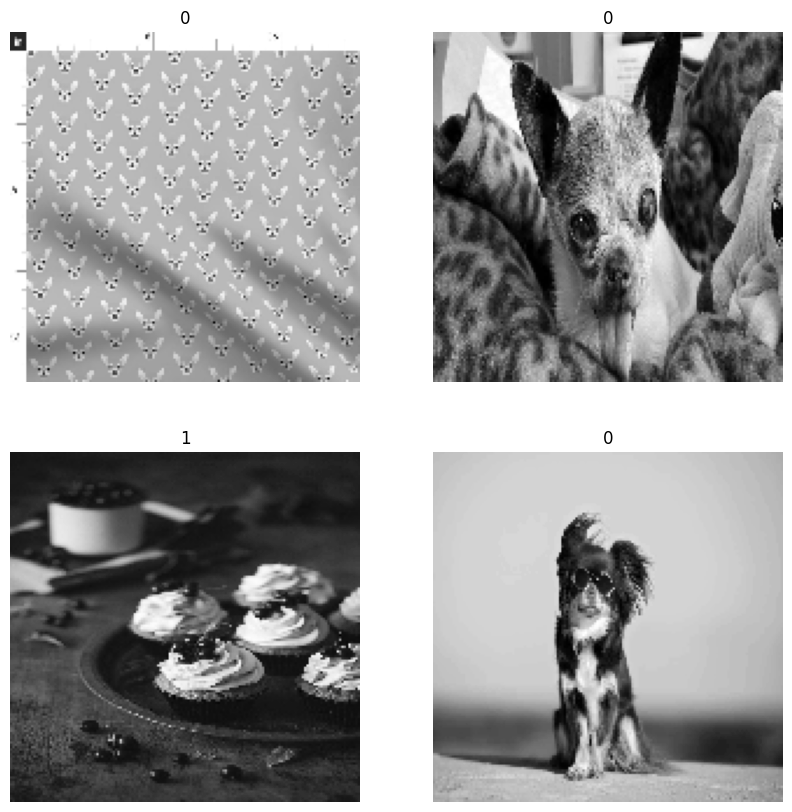

In [22]:
# Visualize images from training set
f, axarr = plt.subplots(2, 2, figsize=(10, 10))
im_index = 0

for row in range(2):
    for column in range(2):
        axarr[row, column].imshow(img_train[im_index], cmap='gray')
        axarr[row, column].axis("off")
        title = label_train[im_index]
        axarr[row,column].set_title(title) # add title to check correspondance
        im_index += 1

plt.show()

## First model

### Architecture 1st model

In [ ]:
# initialize the first model
model0 = Sequential()

# First layer must be input layer or have an input
model0.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(150, 150, 1)))  # Change channels from 1 to 3 if using RGB instead of grayscale
# 16 is the number of filters, each filter is 3x3 pixels, 1 is the stride
model0.add(MaxPooling2D())
# This takes the maximum value after the ReLU and returns it
# Check MaxPooling2D?? for each 2x2 region (pool) takes the highest value

model0.add(Conv2D(32, (3, 3), 1, activation='relu'))  # Now 32 filters
model0.add(MaxPooling2D())

model0.add(Conv2D(64, (3, 3), 1, activation='relu'))
model0.add(MaxPooling2D())

model0.add(Flatten())
# When we apply the conv layer, the filters are going to be the last channel.
# We condense the length and width, then the number of filters will form the
# channel value. When we pass values to the dense layer, we don't want multiple
# values, but we want to 'flatten' them into a single value (thus the Flatten layer).

# Dense layers are fully connected layers
model0.add(Dense(256, activation='relu'))  # 256 values as output
model0.add(Dense(1, activation='sigmoid'))  # 1 output only, due to sigmoid

model0.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
# we use binary cross entropy since it is a classification problem.
#tf.optimizers. to get all the optimizers


model0.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 148, 148, 16)      160       
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_42 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 17, 17, 64)      

### Train 1st model

In [ ]:
#.fit method -> training component
#.predict -> when we make the predictions
hist0 = model0.fit(img_train,
                   label_train,
                   batch_size = 32,
                   epochs = 60,
                   validation_split = 0.15,
                   shuffle = True
                   #callbacks=[early_stopping]
                   )

# With this setup it takes way less to train the model
# Before I tried with tf.keras.utiles.image_from_dataset()
# with data uploaded to drive

Epoch 1/60
126/126 [==============================] - 4s 17ms/step - loss: 0.5841 - accuracy: 0.6811 - val_loss: 0.4952 - val_accuracy: 0.7676
Epoch 2/60
126/126 [==============================] - 2s 14ms/step - loss: 0.4117 - accuracy: 0.8161 - val_loss: 0.4475 - val_accuracy: 0.7972
Epoch 3/60
126/126 [==============================] - 2s 15ms/step - loss: 0.3252 - accuracy: 0.8623 - val_loss: 0.3469 - val_accuracy: 0.8437
Epoch 4/60
126/126 [==============================] - 2s 16ms/step - loss: 0.2368 - accuracy: 0.9031 - val_loss: 0.3705 - val_accuracy: 0.8549
Epoch 5/60
126/126 [==============================] - 2s 14ms/step - loss: 0.2020 - accuracy: 0.9192 - val_loss: 0.3771 - val_accuracy: 0.8437
Epoch 6/60
126/126 [==============================] - 2s 14ms/step - loss: 0.1367 - accuracy: 0.9471 - val_loss: 0.3983 - val_accuracy: 0.8479
Epoch 7/60
126/126 [==============================] - 2s 14ms/step - loss: 0.0739 - accuracy: 0.9746 - val_loss: 0.5085 - val_accuracy: 0.8662

Check Results of Model


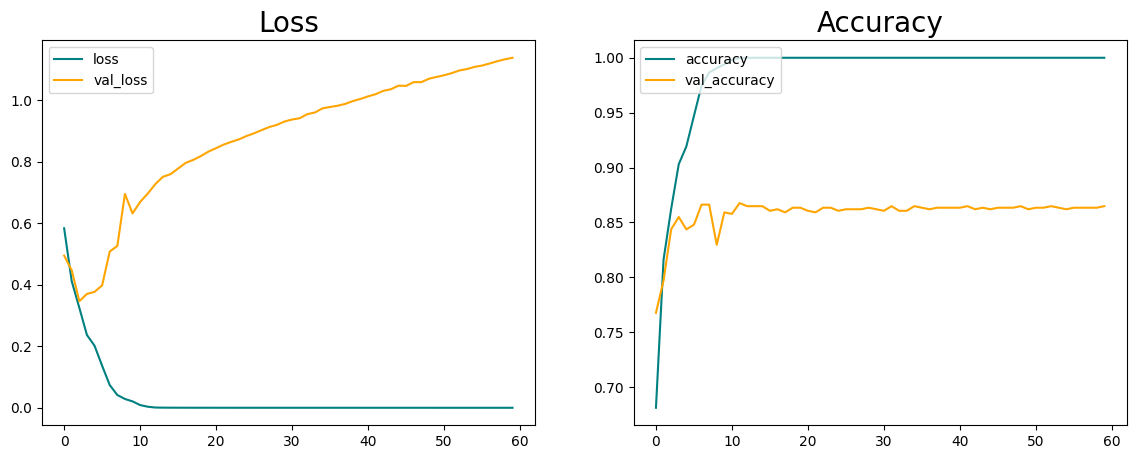

In [ ]:
plot_loss_accuracy(hist0)

### Refine 1st model
The main issue is overfitting, we can try to solve the issue by adding Dropout or a BatchNormalization Layer. After doing this we move to the next model.

The dropout layer is applied on the dense layer before the ouput, using a value of p=0.5, following the methodology of Hinton(2012) (the paper where dropout was initially proposed.

However, according to (more) recent research (Park and Kwak, Analysis on the Dropout Effect in Convolutional Neural Networks), applying a lower level dropout (p=0.1) to convolutional layers can be beneficial.

#### Add dropout

In [ ]:
# first model with dropout
model0d = Sequential()

model0d.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(150, 150, 1)))  # Change channels from 1 to 3 if using RGB instead of grayscale
model0d.add(MaxPooling2D())

model0d.add(Conv2D(32, (3, 3), 1, activation='relu'))
model0d.add(MaxPooling2D())

model0d.add(Conv2D(64, (3, 3), 1, activation='relu'))
model0d.add(MaxPooling2D())

model0d.add(Flatten())

model0d.add(Dense(256, activation='relu'))
model0d.add(Dropout(0.5)) # we add dropout to reduce overfitting
model0d.add(Dense(1, activation='sigmoid'))

model0d.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

model0d.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 148, 148, 16)      160       
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_46 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 17, 17, 64)      

Epoch 1/60
126/126 [==============================] - 4s 17ms/step - loss: 0.5829 - accuracy: 0.6883 - val_loss: 0.4703 - val_accuracy: 0.7859
Epoch 2/60
126/126 [==============================] - 2s 13ms/step - loss: 0.4473 - accuracy: 0.7997 - val_loss: 0.4111 - val_accuracy: 0.8127
Epoch 3/60
126/126 [==============================] - 2s 13ms/step - loss: 0.3530 - accuracy: 0.8439 - val_loss: 0.3684 - val_accuracy: 0.8380
Epoch 4/60
126/126 [==============================] - 2s 15ms/step - loss: 0.2836 - accuracy: 0.8725 - val_loss: 0.3430 - val_accuracy: 0.8606
Epoch 5/60
126/126 [==============================] - 2s 16ms/step - loss: 0.2529 - accuracy: 0.8879 - val_loss: 0.3318 - val_accuracy: 0.8606
Epoch 6/60
126/126 [==============================] - 2s 14ms/step - loss: 0.1875 - accuracy: 0.9222 - val_loss: 0.3269 - val_accuracy: 0.8648
Epoch 7/60
126/126 [==============================] - 2s 13ms/step - loss: 0.1322 - accuracy: 0.9498 - val_loss: 0.3589 - val_accuracy: 0.8662

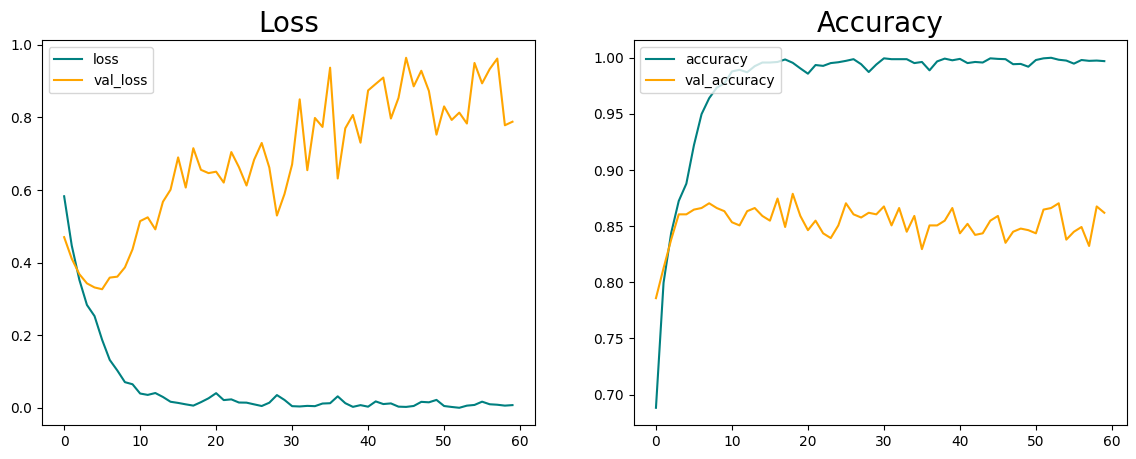

In [ ]:
# get the history of the model with dropout

hist0d = model0d.fit(img_train,
                   label_train,
                   batch_size = 32,
                   epochs = 60,
                   validation_split = 0.15,
                   shuffle = True,
                   #callbacks=[early_stopping]
                  )

plot_loss_accuracy(hist0d)

#### Add L2 regularization
L2 regularization requires the addition of an extra term to the loss function of the network.

In [ ]:
# Initialize the first model
model0_dl2 = Sequential()

# First layer must be input layer or have an input
model0_dl2.add(Conv2D(16, (3, 3), strides=1, activation='relu', input_shape=(150, 150, 1), kernel_regularizer=l2(0.01)))
model0_dl2.add(MaxPooling2D())


model0_dl2.add(Conv2D(32, (3, 3), strides=1, activation='relu', kernel_regularizer=l2(0.01)))
model0_dl2.add(MaxPooling2D())


model0_dl2.add(Conv2D(64, (3, 3), strides=1, activation='relu', kernel_regularizer=l2(0.01)))
model0_dl2.add(MaxPooling2D())


model0_dl2.add(Flatten())
model0_dl2.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model0_dl2.add(Dropout(0.5))

model0_dl2.add(Dense(1, activation='sigmoid'))  # 1 output only, due to sigmoid

model0_dl2.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

model0_dl2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 148, 148, 16)      160       
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_48 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 17, 17, 64)      

Epoch 1/60
126/126 [==============================] - 4s 17ms/step - loss: 1.2281 - accuracy: 0.5777 - val_loss: 0.7075 - val_accuracy: 0.7282
Epoch 2/60
126/126 [==============================] - 2s 14ms/step - loss: 0.6863 - accuracy: 0.7122 - val_loss: 0.6598 - val_accuracy: 0.7169
Epoch 3/60
126/126 [==============================] - 2s 14ms/step - loss: 0.6445 - accuracy: 0.7407 - val_loss: 0.5627 - val_accuracy: 0.8056
Epoch 4/60
126/126 [==============================] - 2s 14ms/step - loss: 0.6401 - accuracy: 0.7308 - val_loss: 0.5592 - val_accuracy: 0.8000
Epoch 5/60
126/126 [==============================] - 2s 15ms/step - loss: 0.6247 - accuracy: 0.7400 - val_loss: 0.5703 - val_accuracy: 0.7915
Epoch 6/60
126/126 [==============================] - 2s 16ms/step - loss: 0.6187 - accuracy: 0.7472 - val_loss: 0.5611 - val_accuracy: 0.7901
Epoch 7/60
126/126 [==============================] - 2s 16ms/step - loss: 0.5898 - accuracy: 0.7649 - val_loss: 0.5357 - val_accuracy: 0.8155

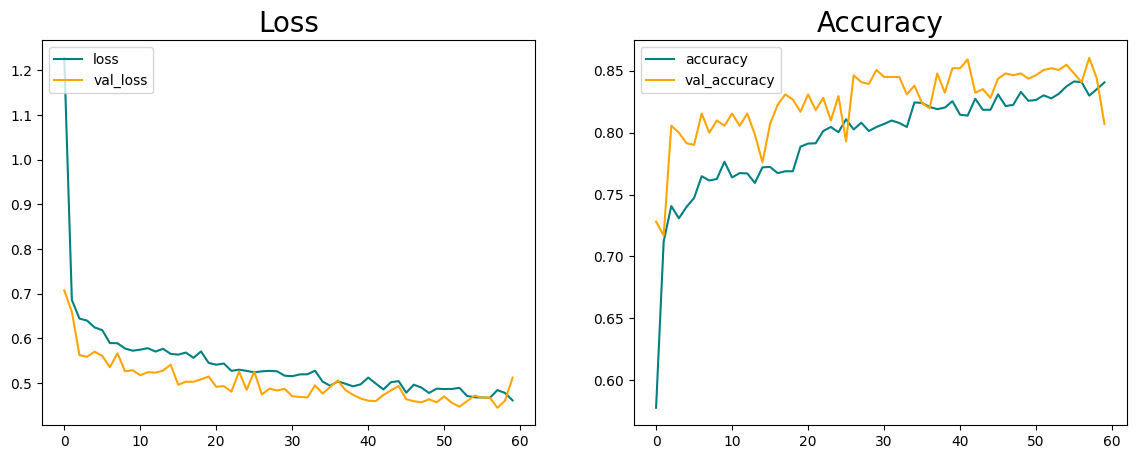

In [ ]:
# get the history of the model with dropout and L2 regularization

hist0_dl2 = model0_dl2.fit(
    img_train,
    label_train,
    batch_size = 32,
    epochs = 60,
    validation_split = 0.15,
    shuffle = True,
    #callbacks=[early_stopping]
    )

plot_loss_accuracy(hist0_dl2)

## Second model
A second fancier model

### Architecture 2nd model

In [37]:
# Initialize the model
model1 = Sequential()

model1.add(Conv2D(16, (3, 3), strides=1, activation='relu', input_shape=(150, 150, 1)))
model1.add(MaxPooling2D())


model1.add(Conv2D(32, (3, 3), strides=1, activation='relu'))

model1.add(MaxPooling2D())


model1.add(Conv2D(64, (3, 3), strides=1, activation='relu'))
model1.add(MaxPooling2D())


model1.add(Conv2D(128, (3, 3), strides=1, activation='relu'))
model1.add(MaxPooling2D())


model1.add(Flatten())

model1.add(Dense(256, activation='relu', ))
model1.add(Dropout(0.5))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

model1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 148, 148, 16)      160       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 17, 17, 64)       

### Train 2nd model

Epoch 1/60
126/126 [==============================] - 3s 10ms/step - loss: 0.6246 - accuracy: 0.6508 - val_loss: 0.4900 - val_accuracy: 0.7831
Epoch 2/60
126/126 [==============================] - 1s 8ms/step - loss: 0.4650 - accuracy: 0.7882 - val_loss: 0.4494 - val_accuracy: 0.8211
Epoch 3/60
126/126 [==============================] - 1s 8ms/step - loss: 0.3913 - accuracy: 0.8233 - val_loss: 0.3569 - val_accuracy: 0.8479
Epoch 4/60
126/126 [==============================] - 1s 8ms/step - loss: 0.3484 - accuracy: 0.8499 - val_loss: 0.3474 - val_accuracy: 0.8549
Epoch 5/60
126/126 [==============================] - 1s 8ms/step - loss: 0.3264 - accuracy: 0.8603 - val_loss: 0.3284 - val_accuracy: 0.8479
Epoch 6/60
126/126 [==============================] - 1s 8ms/step - loss: 0.2695 - accuracy: 0.8852 - val_loss: 0.3209 - val_accuracy: 0.8535
Epoch 7/60
126/126 [==============================] - 1s 8ms/step - loss: 0.2227 - accuracy: 0.9078 - val_loss: 0.3353 - val_accuracy: 0.8521
Epoch

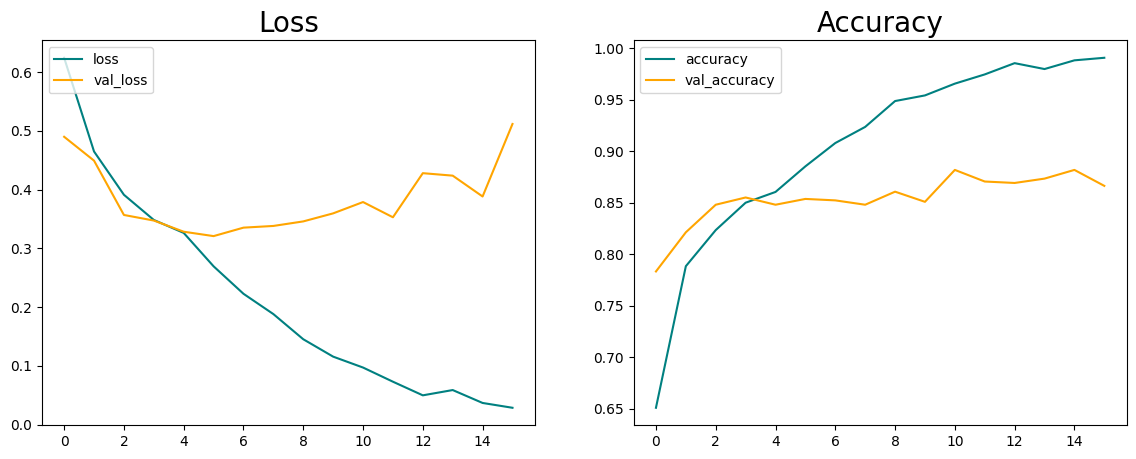

In [38]:
# get the history of the second model (Basic second model, we just add one layer)

hist1 = model1.fit(
    img_train,
    label_train,
    batch_size = 32,
    epochs=60,
    validation_split = 0.15,
    shuffle = True,
    callbacks=[early_stopping]
    )

plot_loss_accuracy(hist1)

### Refine second model

#### Add L2 and BN

In [43]:
# Initialize the model / Model 2 but with L2 and Batch Normalization
model1_bnl2 = Sequential()

model1_bnl2.add(Conv2D(16, (3, 3), strides=1, activation='relu', input_shape=(150, 150, 1)))
model1_bnl2.add(MaxPooling2D())
model1_bnl2.add(BatchNormalization())


model1_bnl2.add(Conv2D(32, (3, 3), strides=1, activation='relu'))
model1_bnl2.add(MaxPooling2D())
model1_bnl2.add(BatchNormalization())

model1_bnl2.add(Conv2D(64, (3, 3), strides=1, activation='relu'))
model1_bnl2.add(MaxPooling2D())
model1_bnl2.add(BatchNormalization())

model1_bnl2.add(Conv2D(128, (3, 3), strides=1, activation='relu', kernel_regularizer=l2(0.01))) # maybe I could drop L2 here
model1_bnl2.add(MaxPooling2D())
model1_bnl2.add(BatchNormalization())

model1_bnl2.add(Flatten())
model1_bnl2.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model1_bnl2.add(Dropout(0.5))
model1_bnl2.add(BatchNormalization())

model1_bnl2.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model1_bnl2.add(Dropout(0.5))
model1_bnl2.add(BatchNormalization())

model1_bnl2.add(Dense(1, activation='sigmoid'))

model1_bnl2.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

model1_bnl2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 148, 148, 16)      160       
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 batch_normalization (Batch  (None, 74, 74, 16)        64        
 Normalization)                                                  
                                                                 
 conv2d_41 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                     

Epoch 1/60
126/126 [==============================] - 1s 11ms/step - loss: 1.1400 - accuracy: 0.8424 - val_loss: 1.6452 - val_accuracy: 0.5437
Epoch 2/60
126/126 [==============================] - 1s 10ms/step - loss: 0.8667 - accuracy: 0.8546 - val_loss: 1.6230 - val_accuracy: 0.5423
Epoch 3/60
126/126 [==============================] - 1s 10ms/step - loss: 0.7804 - accuracy: 0.8610 - val_loss: 1.0139 - val_accuracy: 0.6254
Epoch 4/60
126/126 [==============================] - 1s 10ms/step - loss: 0.7309 - accuracy: 0.8702 - val_loss: 1.1720 - val_accuracy: 0.6859
Epoch 5/60
126/126 [==============================] - 1s 10ms/step - loss: 0.6895 - accuracy: 0.8849 - val_loss: 0.7690 - val_accuracy: 0.8563
Epoch 6/60
126/126 [==============================] - 1s 10ms/step - loss: 0.6905 - accuracy: 0.8958 - val_loss: 0.7785 - val_accuracy: 0.8634
Epoch 7/60
126/126 [==============================] - 1s 10ms/step - loss: 0.7295 - accuracy: 0.8961 - val_loss: 1.3364 - val_accuracy: 0.6521

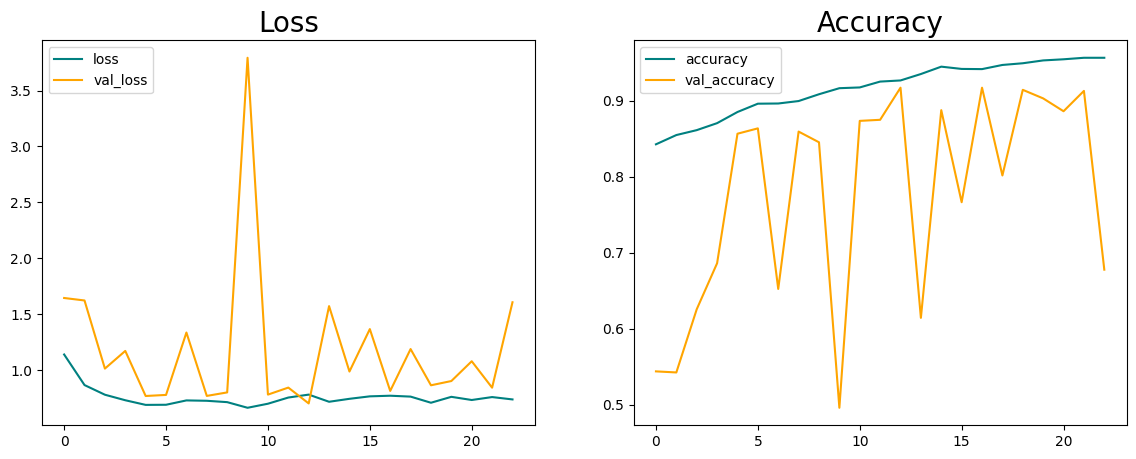

In [45]:
# get the history of the second model

hist1_bnl2 = model1_bnl2.fit(
    img_train,
    label_train,
    batch_size = 32,
    epochs=60,
    validation_split = 0.15,
    shuffle = True,
    callbacks=[early_stopping]
    )

plot_loss_accuracy(hist1_bnl2)

#### Add only L2


In [41]:
# Initialize the model
model1_l2 = Sequential()

model1_l2.add(Conv2D(16, (3, 3), strides=1, activation='relu', input_shape=(150, 150, 1)))
model1_l2.add(MaxPooling2D())


model1_l2.add(Conv2D(32, (3, 3), strides=1, activation='relu'))
model1_l2.add(MaxPooling2D())


model1_l2.add(Conv2D(64, (3, 3), strides=1, activation='relu'))
model1_l2.add(MaxPooling2D())


model1_l2.add(Conv2D(128, (3, 3), strides=1, activation='relu'))
model1_l2.add(MaxPooling2D())


model1_l2.add(Flatten())
model1_l2.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model1_l2.add(Dropout(0.5))
model1.add(Dense(64, activation='relu',kernel_regularizer=l2(0.01)))
model1_l2.add(Dropout(0.5))

model1_l2.add(Dense(1, activation='sigmoid'))

model1_l2.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

model1_l2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 148, 148, 16)      160       
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 17, 17, 64)      

Epoch 1/60
126/126 [==============================] - 3s 10ms/step - loss: 1.1256 - accuracy: 0.5431 - val_loss: 0.6606 - val_accuracy: 0.5606
Epoch 2/60
126/126 [==============================] - 1s 8ms/step - loss: 0.6267 - accuracy: 0.7032 - val_loss: 0.5927 - val_accuracy: 0.7183
Epoch 3/60
126/126 [==============================] - 1s 8ms/step - loss: 0.5667 - accuracy: 0.7489 - val_loss: 0.5024 - val_accuracy: 0.8014
Epoch 4/60
126/126 [==============================] - 1s 8ms/step - loss: 0.5586 - accuracy: 0.7539 - val_loss: 0.4719 - val_accuracy: 0.8056
Epoch 5/60
126/126 [==============================] - 1s 8ms/step - loss: 0.5267 - accuracy: 0.7805 - val_loss: 0.4903 - val_accuracy: 0.8014
Epoch 6/60
126/126 [==============================] - 1s 8ms/step - loss: 0.4907 - accuracy: 0.7999 - val_loss: 0.4653 - val_accuracy: 0.8155
Epoch 7/60
126/126 [==============================] - 1s 8ms/step - loss: 0.4836 - accuracy: 0.8004 - val_loss: 0.4216 - val_accuracy: 0.8437
Epoch

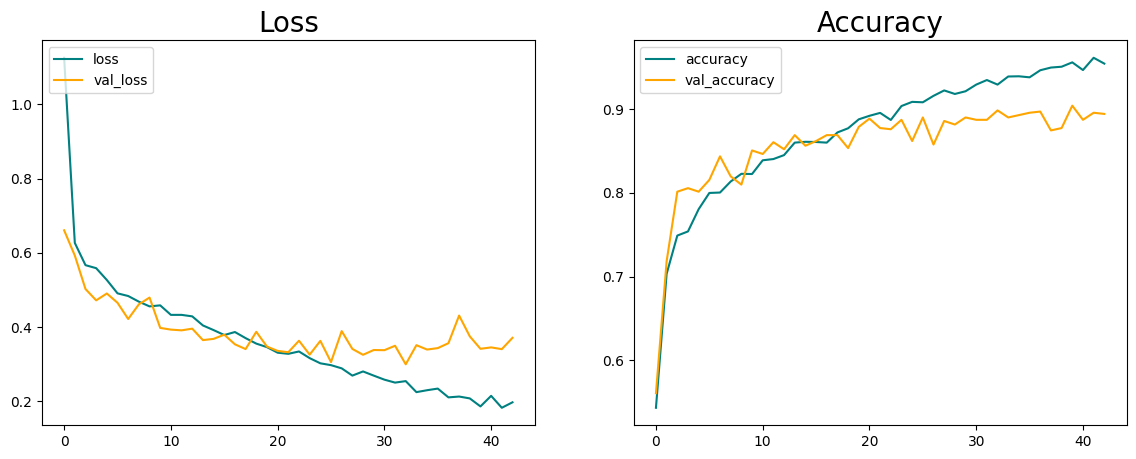

In [42]:
hist1l2 = model1_l2.fit(
    img_train,
    label_train,
    batch_size = 32,
    epochs=60,
    validation_split = 0.15,
    shuffle = True,
    callbacks=[early_stopping]
    )

plot_loss_accuracy(hist1l2)

#### Add only BN



In [ ]:
# Initialize the model
model1_bn = Sequential()

model1_bn.add(Conv2D(16, (3, 3), strides=1, activation='relu', input_shape=(150, 150, 1)))
model1_bn.add(MaxPooling2D())
model1_bn.add(BatchNormalization())

model1_bn.add(Conv2D(32, (3, 3), strides=1, activation='relu'))
model1_bn.add(MaxPooling2D())
model1_bn.add(BatchNormalization())

model1_bn.add(Conv2D(64, (3, 3), strides=1, activation='relu'))
model1_bn.add(MaxPooling2D())
model1_bn.add(BatchNormalization())

model1_bn.add(Conv2D(128, (3, 3), strides=1, activation='relu'))
model1_bn.add(MaxPooling2D())
model1_bn.add(BatchNormalization())

model1_bn.add(Flatten())
model1_bn.add(Dense(256, activation='relu'))
model1_bn.add(Dropout(0.5))
model1_bn.add(BatchNormalization())


model1_bn.add(Dense(1, activation='sigmoid'))

model1_bn.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

model1_bn.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_62 (Conv2D)          (None, 148, 148, 16)      160       
                                                                 
 max_pooling2d_58 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_14 (Ba  (None, 74, 74, 16)        64        
 tchNormalization)                                               
                                                                 
 conv2d_63 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_59 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                     

Epoch 1/60
126/126 [==============================] - 5s 20ms/step - loss: 0.5148 - accuracy: 0.7783 - val_loss: 1.5701 - val_accuracy: 0.5437
Epoch 2/60
126/126 [==============================] - 2s 17ms/step - loss: 0.3456 - accuracy: 0.8566 - val_loss: 2.2035 - val_accuracy: 0.5437
Epoch 3/60
126/126 [==============================] - 2s 16ms/step - loss: 0.2487 - accuracy: 0.8986 - val_loss: 1.8224 - val_accuracy: 0.5437
Epoch 4/60
126/126 [==============================] - 2s 15ms/step - loss: 0.2010 - accuracy: 0.9192 - val_loss: 0.6665 - val_accuracy: 0.7028
Epoch 5/60
126/126 [==============================] - 2s 15ms/step - loss: 0.1102 - accuracy: 0.9565 - val_loss: 0.5265 - val_accuracy: 0.8014
Epoch 6/60
126/126 [==============================] - 2s 15ms/step - loss: 0.0774 - accuracy: 0.9769 - val_loss: 0.3115 - val_accuracy: 0.8873
Epoch 7/60
126/126 [==============================] - 2s 15ms/step - loss: 0.0775 - accuracy: 0.9756 - val_loss: 0.3810 - val_accuracy: 0.8563

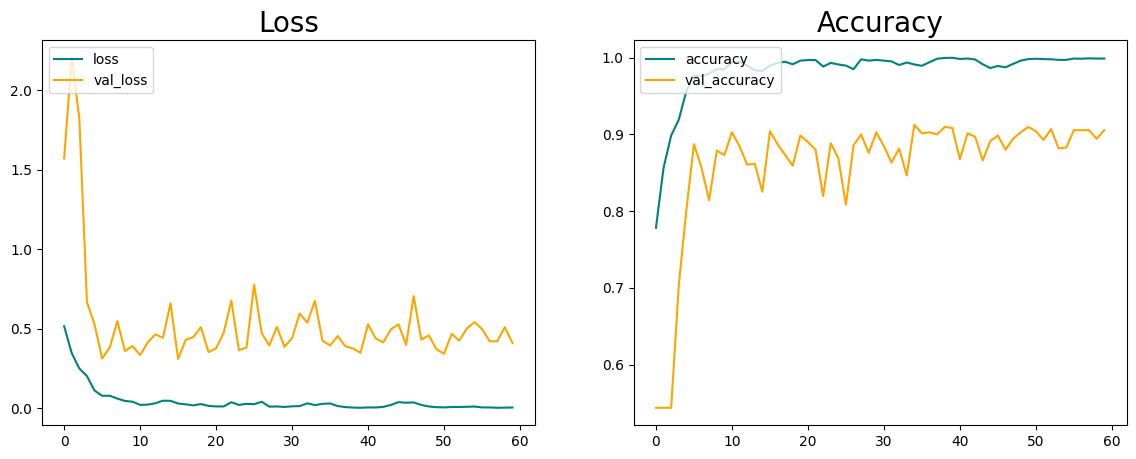

In [ ]:
hist1bn = model1_bn.fit(
    img_train,
    label_train,
    batch_size = 32,
    epochs=60,
    validation_split = 0.15,
    shuffle = True,
    #callbacks=[early_stopping]
    )

plot_loss_accuracy(hist1bn)

## Third Model
This third model is inspired by the VGG16 architecture.
It includes blocks of convolutional layers, followed by max-pooling layers.

### Architecture 3rd model
The 3rd model was first run by removing the hash in the following code. <br>
After notifice the unsatisfying performance, I dropped the second convolutional layer for each block.
The result is what has been named "refined" third model in the report.

In [25]:
# Initialize the model
model2 = Sequential()

# Block 1
model2.add(Conv2D(32, (3, 3), strides=1, activation='relu', input_shape=(150, 150, 1), padding='same'))
#model2.add(Conv2D(32, (3, 3), strides=1, activation='relu', padding='same'))
model2.add(MaxPooling2D())

# Block 2
model2.add(Conv2D(64, (3, 3), strides=1, activation='relu', padding='same'))
#model2.add(Conv2D(64, (3, 3), strides=1, activation='relu', padding='same'))
model2.add(MaxPooling2D())

# Block 3
model2.add(Conv2D(128, (3, 3), strides=1, activation='relu', padding='same'))
#model2.add(Conv2D(128, (3, 3), strides=1, activation='relu', padding='same'))
model2.add(MaxPooling2D())

# Block 4
model2.add(Conv2D(256, (3, 3), strides=1, activation='relu', padding='same'))
#model2.add(Conv2D(256, (3, 3), strides=1, activation='relu', padding='same'))
model2.add(MaxPooling2D())

# Flatten and Dense layers
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

# Summary of the model
model2.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 37, 37, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 18, 18, 128)      

### Train 3rd model

In [27]:
# Fit the model
hist2 = model2.fit(img_train,
                   label_train,
                   epochs=60,
                   validation_split = 0.15,
                   shuffle = True,
                   callbacks=[early_stopping]
                   )

Epoch 1/60
126/126 [==============================] - 2s 19ms/step - loss: 0.0443 - accuracy: 0.9858 - val_loss: 0.5850 - val_accuracy: 0.8845
Epoch 2/60
126/126 [==============================] - 2s 19ms/step - loss: 0.0316 - accuracy: 0.9920 - val_loss: 0.6819 - val_accuracy: 0.8690
Epoch 3/60
126/126 [==============================] - 2s 19ms/step - loss: 0.0437 - accuracy: 0.9866 - val_loss: 0.6207 - val_accuracy: 0.8507
Epoch 4/60
126/126 [==============================] - 2s 19ms/step - loss: 0.0329 - accuracy: 0.9913 - val_loss: 0.7148 - val_accuracy: 0.8648
Epoch 5/60
126/126 [==============================] - 2s 19ms/step - loss: 0.0216 - accuracy: 0.9920 - val_loss: 0.8176 - val_accuracy: 0.8634
Epoch 6/60
126/126 [==============================] - 2s 19ms/step - loss: 0.0218 - accuracy: 0.9938 - val_loss: 0.8208 - val_accuracy: 0.8761
Epoch 7/60
126/126 [==============================] - 2s 18ms/step - loss: 0.0483 - accuracy: 0.9856 - val_loss: 0.6335 - val_accuracy: 0.8479

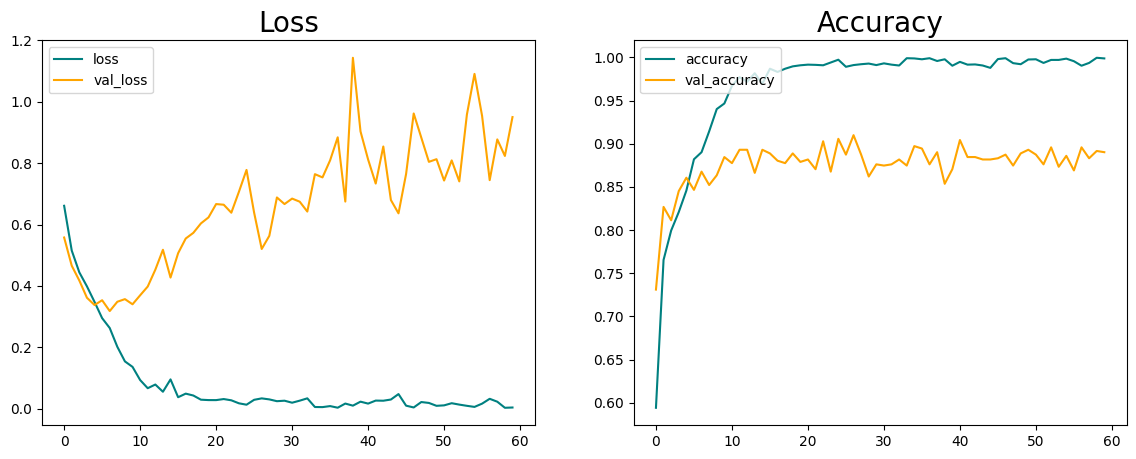

In [ ]:
plot_loss_accuracy(hist2)

## Hyperparameter tuning
Take the best version of the first two models, then:

*   Establish which hyperparameters can be optimized
*   For each model, perform grid search of the hyperparameters
*   For each model, take the best combination of hyperparameters
*   Train the model with the best hyperparameters


### Hyperparameter tuning  **first** model
model1d -> model with dropout
Hyperparameters:
- learning rate
- dropout rate
- batch size

In [9]:
# Function to calculate average validation accuracy and standard deviation
def evaluate_model_performance(history, num_epochs=5):
    val_accuracies = history.history['val_accuracy'][-num_epochs:] #take only the last 5 epochs
    avg_val_accuracy = np.mean(val_accuracies)
    std_val_accuracy = np.std(val_accuracies)
    return avg_val_accuracy, std_val_accuracy

#### Tune learning rate, batch size and dropout rate

In [ ]:
# Hyperparameter ranges
learning_rates = [0.005, 0.001, 0.0005] #changed them from 0.01, 0.001, 0.0001
batch_sizes = [32, 64]
dropout_rates = [0.5, 0.7, 0.9]
l2_lambdas = [0.001, 0.01, 0.1] # necessary for 2nd and third model

# List of all combinations of hyperparameters
hyperparameters = list(itertools.product(learning_rates, batch_sizes, dropout_rates))

In [ ]:
# Function to build and compile the model
def build_model1(learning_rate, dropout_rate):
    model = Sequential()

    model.add(Conv2D(16, (3, 3), strides=1, activation='relu', input_shape=(150, 150, 1)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3, 3), strides=1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, (3, 3), strides=1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=tf.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

In [ ]:
# Iterate through all combinations of hyperparameters
results = []
for lr, bs, dr in hyperparameters:
    print(f'Training with learning rate: {lr}, batch size: {bs}, dropout rate: {dr}')
    model = build_model1(lr, dr)
    history = model.fit(img_train, label_train, batch_size=bs, epochs=30, validation_split=0.15, callbacks = [early_stopping], shuffle=True)
    avg_val_accuracy, std_val_accuracy = evaluate_model_performance(history)
    results.append((lr, bs, dr, avg_val_accuracy, std_val_accuracy))
    print(f'Average validation accuracy: {avg_val_accuracy}, Standard deviation: {std_val_accuracy}')



In [ ]:
# Find the best hyperparameters based on average validation accuracy and stability (lower std deviation)
best_hyperparameters = max(results, key=lambda x: (x[3], -x[4]))
print(f'Best hyperparameters: Learning rate={best_hyperparameters[0]}, Batch size={best_hyperparameters[1]}, Dropout rate={best_hyperparameters[2]}')
print(f'Average validation accuracy: {best_hyperparameters[3]}, Standard deviation: {best_hyperparameters[4]}')

Best hyperparameters: Learning rate=0.001, Batch size=32, Dropout rate=0.9
Average validation accuracy: 0.8946478843688965, Standard deviation: 0.0037157495905255637


Best hyperparameters first model
1.   Learning rate=0.001
2.   Batch size=32
3.   Dropout rate = 0.9

Average validation accuracy: 0.894

#### Tune the number of filters for each convolutional layer

Now I search for the best number of filters for each layer. The number of filter will be increasing in depth, as it is

In [16]:
# Hyperparameters from previous tuning
#best_lr = best_hyperparameters[0]
#best_bs = best_hyperparameters[1]
#best_dr = best_hyperparameters[2]

# I cannot afford computationally to fill "results". I should have pickled the
# 'result' list, but Colab kicked me out right after the hyperparameter tuning
best_lr = 0.001
best_bs = 32
best_dr = 0.9

# Filter sizes to explore
filters_layer1 = [16, 32, 64]
filters_layer2 = [32, 64, 128]
filters_layer3 = [64, 128, 256]
filters_layer4 =  [64, 128, 256] # needed for second model

# List of all combinations of filter sizes
filter_combinations = list(itertools.product(filters_layer1, filters_layer2, filters_layer3))

# Function to try each combination of filters
def build_model_with_filters(filters1, filters2, filters3, learning_rate, dropout_rate):
    model = Sequential()

    model.add(Conv2D(filters1, (3, 3), strides=1, activation='relu', input_shape=(150, 150, 1)))
    model.add(MaxPooling2D())

    model.add(Conv2D(filters2, (3, 3), strides=1, activation='relu'))
    model.add(MaxPooling2D())

    model.add(Conv2D(filters3, (3, 3), strides=1, activation='relu'))
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
    return model

In [ ]:
# Iterate through all combinations of filter sizes
results_filters = []
for f1, f2, f3 in filter_combinations:
    print(f'Training with filters: {f1}, {f2}, {f3}')
    model = build_model_with_filters(f1, f2, f3, best_lr, best_dr)
    history = model.fit(img_train, label_train, batch_size=best_bs, epochs=30, validation_split=0.15, callbacks=[early_stopping], shuffle=True)
    avg_val_accuracy, std_val_accuracy = evaluate_model_performance(history)
    results_filters.append((f1, f2, f3, avg_val_accuracy, std_val_accuracy))
    print(f'Average validation accuracy: {avg_val_accuracy}, Standard deviation: {std_val_accuracy}')

best_filters = max(results, key=lambda x: (x[3]))
print(f'Best filters: Layer 1={best_filters[0]}, Layer 2={best_filters[1]}, Layer 3={best_filters[2]}')
print(f'Average validation accuracy: {best_filters[3]}, Standard deviation: {best_filters[4]}')

#### Results of the final version of the first model

Epoch 1/60
126/126 [==============================] - 3s 12ms/step - loss: 0.6933 - accuracy: 0.5349 - val_loss: 0.6896 - val_accuracy: 0.5437
Epoch 2/60
126/126 [==============================] - 1s 9ms/step - loss: 0.6855 - accuracy: 0.5496 - val_loss: 0.6674 - val_accuracy: 0.7352
Epoch 3/60
126/126 [==============================] - 1s 9ms/step - loss: 0.6123 - accuracy: 0.6480 - val_loss: 0.5035 - val_accuracy: 0.7831
Epoch 4/60
126/126 [==============================] - 1s 9ms/step - loss: 0.5521 - accuracy: 0.7082 - val_loss: 0.4797 - val_accuracy: 0.8225
Epoch 5/60
126/126 [==============================] - 1s 9ms/step - loss: 0.5225 - accuracy: 0.7236 - val_loss: 0.4933 - val_accuracy: 0.7944
Epoch 6/60
126/126 [==============================] - 1s 9ms/step - loss: 0.5104 - accuracy: 0.7271 - val_loss: 0.4891 - val_accuracy: 0.8282
Epoch 7/60
126/126 [==============================] - 1s 9ms/step - loss: 0.4655 - accuracy: 0.7539 - val_loss: 0.4485 - val_accuracy: 0.8183
Epoch

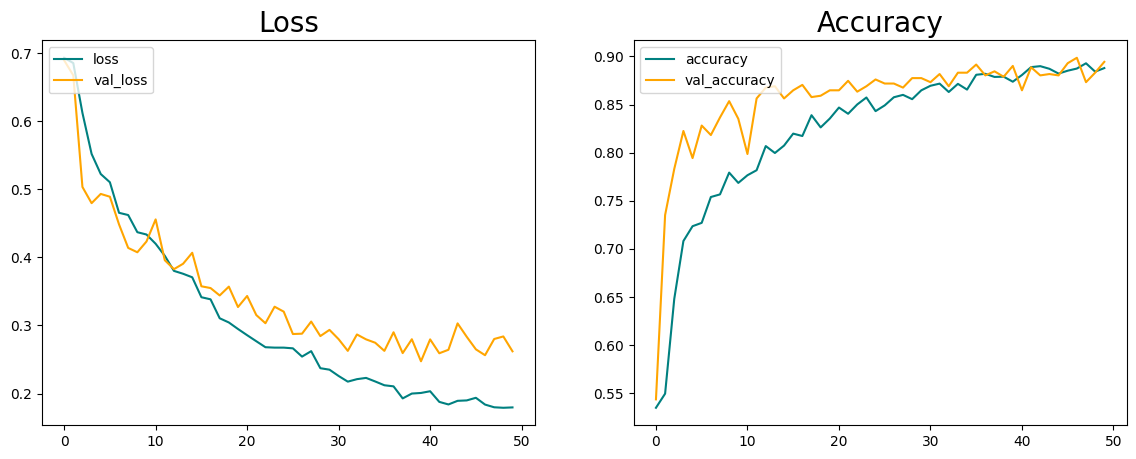

In [17]:
best_filter1, best_filter2, best_filter3 =  16 , 64 , 64

final_model1 = build_model_with_filters(best_filter1, best_filter2, best_filter3, best_lr, best_dr)
hist_final1 = final_model1.fit(img_train, label_train, batch_size=best_bs, epochs=60, validation_split=0.15, callbacks=[early_stopping], shuffle=True)

plot_loss_accuracy(hist_final1)


### Hyperparameter tuning second model


#### Tune lr, dr, bs, L2lam

In [ ]:
# Compute again all combinations, now with l2_lambdas / used also for 3rd model
hyperparameters2 = list(itertools.product(learning_rates,
                                         batch_sizes,
                                         dropout_rates,
                                         l2_lambdas))

# Function to build and compile the model
def build_model2(learning_rate, dropout_rate, l2_lambda):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), strides=1, activation='relu', input_shape=(150, 150, 1)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3, 3), strides=1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, (3, 3), strides=1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (3, 3), strides=1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(l2_lambda)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer= Adam(learning_rate=learning_rate), loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
    return model




In [ ]:
results2 = []
for lr, bs, dr, l2_lambda in hyperparameters2:
    print(f'Training with learning rate: {lr}, batch size: {bs}, dropout rate: {dr}, L2 lambda: {l2_lambda}')
    model = build_model2(lr, dr, l2_lambda)
    history2 = model.fit(img_train, label_train, batch_size=bs, epochs=30, validation_split=0.15, callbacks = early_stopping, shuffle=True)
    avg_val_accuracy, std_val_accuracy = evaluate_model_performance(history2)
    results2.append((lr, bs, dr, l2_lambda, avg_val_accuracy, std_val_accuracy))
    print(f'Average validation accuracy: {avg_val_accuracy}, Standard deviation: {std_val_accuracy}')



In [ ]:
# Find the best hyperparameters
best_hyperparameters2 = max(results2, key=lambda x: (x[4]))
print(f'Best hyperparameters: Learning rate={best_hyperparameters2[0]}, Batch size={best_hyperparameters2[1]}, Dropout rate={best_hyperparameters2[2]}, L2 lambda={best_hyperparameters2[3]}')
print(f'Average validation accuracy: {best_hyperparameters2[4]}, Standard deviation: {best_hyperparameters2[5]}')

Best hyperparameters: Learning rate=0.001, Batch size=32, Dropout rate=0.7, L2 lambda=0.01
Average validation accuracy: 0.9042253375053406, Standard deviation: 0.004272040311629503


Best hyperparameters second model:
1. Learning rate=0.001
2. Batch size = 32
3. Dropout rate = 0.7
4. L2 lambda = 0.01
Average validation accuracy = 0.904

#### Tune the number of filters for each convolutional layer


In [20]:
# I don't fectch them from 'results2' because of computational issues.
# I should have pickled 'results2', but it's too late.
best_lr2, best_bs2, best_dr2, best_lam = 0.001, 32, 0.7, 0.01

# compute again the filter combinations, this time with 4 layers
filter_combinations2 = list(itertools.product(filters_layer1, filters_layer2, filters_layer3, filters_layer4))

In [21]:
# Re-use the first model function, but add other parameters
# I realized I could have made a unique function with all parameters at the beginning of the code and re-used it.
def build_model_with_filters2(filters1, filters2, filters3, filters4, learning_rate, dropout_rate, l2lam):
  model = Sequential()

  model.add(Conv2D(filters1, (3, 3), strides=1, activation='relu', input_shape=(150, 150, 1)))
  model.add(MaxPooling2D())

  model.add(Conv2D(filters2, (3, 3), strides=1, activation='relu'))
  model.add(MaxPooling2D())

  model.add(Conv2D(filters3, (3, 3), strides=1, activation='relu'))
  model.add(MaxPooling2D())

  model.add(Conv2D(filters4, (3, 3), strides=1, activation='relu'))
  model.add(MaxPooling2D())

  model.add(Flatten())
  model.add(Dense(256, activation='relu', kernel_regularizer=l2(l2lam)))
  model.add(Dropout(dropout_rate))

  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer= Adam(learning_rate = learning_rate),
                loss=tf.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

  return model

In [ ]:
# Iterate through all combinations of filter sizes
results2_filter = []
for f1, f2, f3, f4 in filter_combinations:
    print(f'Training with filters: {f1}, {f2}, {f3}, {f4}')
    model = build_model_with_filters2(f1, f2, f3, f4, best_lr2, best_dr2, best_lam)
    history = model.fit(img_train, label_train, batch_size=best_bs2, epochs=30, validation_split=0.15, callbacks=[early_stopping], shuffle=True)
    avg_val_accuracy, std_val_accuracy = evaluate_model_performance(history)
    results.append((f1, f2, f3, f4, avg_val_accuracy, std_val_accuracy))
    print(f'Average validation accuracy: {avg_val_accuracy}, Standard deviation: {std_val_accuracy}')

best_filters2 = max(results, key=lambda x: (x[4]))
print(f'Best filters: Layer 1={best_filters2[0]}, Layer 2={best_filters2[1]}, Layer 3={best_filters2[2]}, Layer 4 = {best_filters2[3]}')
print(f'Average validation accuracy: {best_filters2[4]}, Standard deviation: {best_filters2[5]}')

Training with filters: 16, 32, 64, 64
Epoch 1/30
126/126 [==============================] - 88s 686ms/step - loss: 1.1829 - accuracy: 0.6348 - val_loss: 0.5928 - val_accuracy: 0.7732
Epoch 2/30
126/126 [==============================] - 85s 672ms/step - loss: 0.5960 - accuracy: 0.7315 - val_loss: 0.5619 - val_accuracy: 0.7577
Epoch 3/30
126/126 [==============================] - 82s 649ms/step - loss: 0.5353 - accuracy: 0.7810 - val_loss: 0.4558 - val_accuracy: 0.8141
Epoch 4/30
126/126 [==============================] - 84s 671ms/step - loss: 0.5102 - accuracy: 0.7942 - val_loss: 0.4534 - val_accuracy: 0.8239
Epoch 5/30
126/126 [==============================] - 86s 682ms/step - loss: 0.4979 - accuracy: 0.8006 - val_loss: 0.4758 - val_accuracy: 0.8211
Epoch 6/30
126/126 [==============================] - 82s 650ms/step - loss: 0.4937 - accuracy: 0.8024 - val_loss: 0.4279 - val_accuracy: 0.8394
Epoch 7/30
126/126 [==============================] - 83s 658ms/step - loss: 0.4683 - accura

NameError: name 'evaluate_model_performance' is not defined

I could tune the dense layer

#### Train the final version of the second model

In [22]:
best_filter1_2, best_filter2_2, best_filter3_2, best_filter4 = 16 , 64 , 128 , 256 # didn't actually perform cross validation

Epoch 1/60
126/126 [==============================] - 5s 17ms/step - loss: 1.0106 - accuracy: 0.5367 - val_loss: 0.6911 - val_accuracy: 0.5437
Epoch 2/60
126/126 [==============================] - 1s 11ms/step - loss: 0.6626 - accuracy: 0.6271 - val_loss: 0.5758 - val_accuracy: 0.7549
Epoch 3/60
126/126 [==============================] - 1s 11ms/step - loss: 0.5452 - accuracy: 0.7703 - val_loss: 0.4735 - val_accuracy: 0.8268
Epoch 4/60
126/126 [==============================] - 1s 11ms/step - loss: 0.5273 - accuracy: 0.7890 - val_loss: 0.4886 - val_accuracy: 0.8000
Epoch 5/60
126/126 [==============================] - 1s 11ms/step - loss: 0.5029 - accuracy: 0.7942 - val_loss: 0.4660 - val_accuracy: 0.8225
Epoch 6/60
126/126 [==============================] - 1s 11ms/step - loss: 0.4855 - accuracy: 0.8064 - val_loss: 0.4700 - val_accuracy: 0.8268
Epoch 7/60
126/126 [==============================] - 1s 11ms/step - loss: 0.4598 - accuracy: 0.8175 - val_loss: 0.4346 - val_accuracy: 0.8268

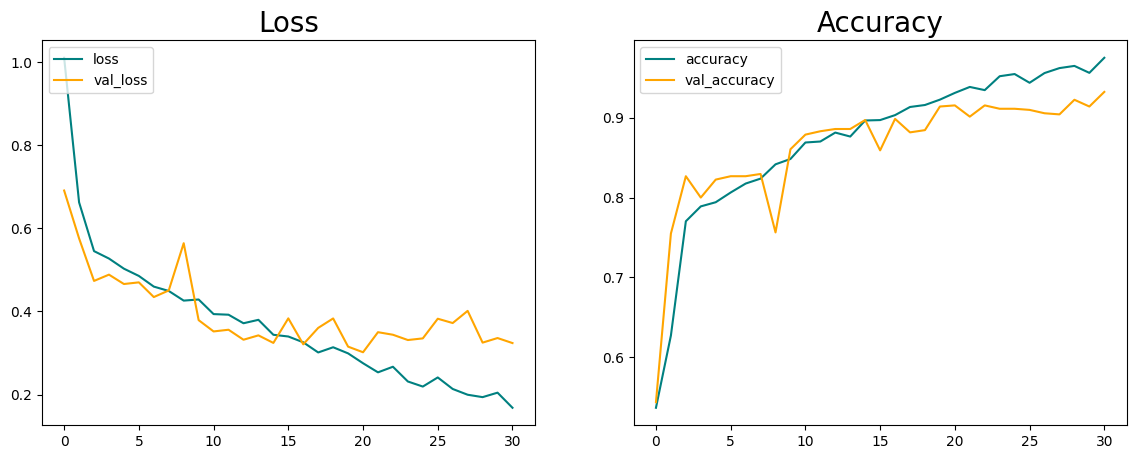

In [24]:
final_model2 = build_model_with_filters2(best_filter1_2, best_filter2_2, best_filter3_2, best_filter4, best_lr2, best_dr2, best_lam)
hist_final2 = final_model2.fit(img_train, label_train, batch_size=best_bs2, epochs=60, validation_split=0.15, callbacks=[early_stopping], shuffle=True)

plot_loss_accuracy(hist_final2)

## Evaluate performance of the models
- Compute 5-fold CV risk of the three final models.
- Run the three final models on the test set.
- Get performance metrics on the test set.


### Cross Validated Risk
Use 5-fold CV to compute risk estimates, with 0-1 loss.

I should do this with the tuned models.

#### CV First Model

In [46]:
# initialize empty lists where I will save results
accuracies1=[]
zero_one_losses1=[]

k_fold=KFold(n_splits=5, shuffle=True, random_state=42)
index=1
for train_index,test_index in k_fold.split(img_train):
  # divide in training and validation
  img_train_cv, img_val_cv = img_train[train_index], img_train[test_index]
  label_train_cv, label_val_cv = label_train[train_index], label_train[test_index]

  print("\n Cycle #"+str(index))

  hist = final_model1.fit(
  x = img_train_cv,
  y = label_train_cv,
  epochs=60,
  batch_size = best_bs,
  validation_data=(img_val_cv, label_val_cv),
  shuffle=True
  )

  loss, accuracy = final_model1.evaluate(img_val_cv, label_val_cv)
  zero_one_loss = 1-accuracy
  zero_one_losses1.append(zero_one_loss)
  accuracies1.append(accuracy)

  index += 1

print('0-1 Losses:',zero_one_losses1)
avg_loss1 = np.mean(zero_one_losses1)
print("Zero-One Loss: {}".format(avg_loss1))
print('Accuracies:',accuracies1)
avg_acc1 = np.mean(accuracies1)
print("AVG Accuracy: {}".format(avg_acc1))


 Cycle #1
Epoch 1/60
119/119 [==============================] - 2s 14ms/step - loss: 0.2306 - accuracy: 0.8745 - val_loss: 0.1628 - val_accuracy: 0.9630
Epoch 2/60
119/119 [==============================] - 1s 10ms/step - loss: 0.2205 - accuracy: 0.8700 - val_loss: 0.1406 - val_accuracy: 0.9683
Epoch 3/60
119/119 [==============================] - 1s 10ms/step - loss: 0.2187 - accuracy: 0.8719 - val_loss: 0.1646 - val_accuracy: 0.9620
Epoch 4/60
119/119 [==============================] - 1s 10ms/step - loss: 0.2206 - accuracy: 0.8782 - val_loss: 0.1384 - val_accuracy: 0.9662
Epoch 5/60
119/119 [==============================] - 1s 10ms/step - loss: 0.1980 - accuracy: 0.8724 - val_loss: 0.1604 - val_accuracy: 0.9578
Epoch 6/60
119/119 [==============================] - 1s 10ms/step - loss: 0.2069 - accuracy: 0.8798 - val_loss: 0.1606 - val_accuracy: 0.9694
Epoch 7/60
119/119 [==============================] - 1s 10ms/step - loss: 0.2081 - accuracy: 0.8819 - val_loss: 0.1580 - val_accur

In [51]:
print(accuracies)
print(zero_one_losses)
print(f"The average validation accuracy is: {np.mean(accuracies):.2f}")
print(f"The average validation accuracy is: {np.mean(zero_one_losses):.4f}")

[0.9598732590675354, 0.9799366593360901, 0.9894403219223022, 0.9947145581245422, 0.9968287348747253]
[0.0401267409324646, 0.020063340663909912, 0.010559678077697754, 0.005285441875457764, 0.003171265125274658]
The average validation accuracy is: 0.98
The average validation accuracy is: 0.0158


#### CV Second Model

In [ ]:
# initialize empty lists where I will save results
accuracies2=[]
zero_one_losses2=[]

k_fold=KFold(n_splits=5, shuffle=True, random_state=42)
index=1
for train_index,test_index in k_fold.split(img_train):
  # divide in training and validation
  img_train_cv, img_val_cv = img_train[train_index], img_train[test_index]
  label_train_cv, label_val_cv = label_train[train_index], label_train[test_index]

  print("\n Cycle #"+str(index))

  hist = final_model2.fit(
  x = img_train_cv,
  y = label_train_cv,
  epochs=60,
  batch_size= best_bs2,
  validation_data=(img_val_cv, label_val_cv),
  shuffle=True
  )

  loss, accuracy = final_model2.evaluate(img_val_cv, label_val_cv)
  zero_one_loss2 = 1-accuracy
  zero_one_losses2.append(zero_one_loss)
  accuracies2.append(accuracy)

  index += 1

print('0-1 Losses:',zero_one_losses2)
avg_loss2 = np.mean(zero_one_losses2)
print("Zero-One Loss: {}".format(avg_loss2))
print('Accuracies:',accuracies2)
avg_acc2 = np.mean(accuracies2)
print("AVG Accuracy: {}".format(avg_acc2))

#### CV Third Model

In [ ]:
# initialize empty lists where I will save results
accuracies3=[]
zero_one_losses3=[]

k_fold=KFold(n_splits=5, shuffle=True, random_state=42)
index=1
for train_index,test_index in k_fold.split(img_train):
  # divide in training and validation
  img_train_cv, img_val_cv = img_train[train_index], img_train[test_index]
  label_train_cv, label_val_cv = label_train[train_index], label_train[test_index]

  print("\n Cycle #"+str(index))

  hist = model2.fit(
  x = img_train_cv,
  y = label_train_cv,
  epochs=60,
  batch_size=32,
  validation_data=(img_val_cv, label_val_cv),
  shuffle=True
  )

  loss, accuracy = model2.evaluate(img_val_cv, label_val_cv)
  zero_one_loss3 = 1-accuracy
  zero_one_losses3.append(zero_one_loss)
  accuracies3.append(accuracy)

  index += 1

print('0-1 Losses:',zero_one_losses3)
avg_loss3 = np.mean(zero_one_losses3)
print("Zero-One Loss: {}".format(avg_loss3))
print('Accuracies:',accuracies3)
avg_acc3 = np.mean(accuracies3)
print("AVG Accuracy: {}".format(avg_acc3))

### Evaluation metrics

*   Make predictions on the test set
*   Initialize/Update metrics
*   Get the resulting metrics


Try to create a for loop where thic can be done for all the final models



In [52]:
final_model1.evaluate(img_test,label_test,batch_size=32)

37/37 [==============================] - 0s 5ms/step - loss: 0.5164 - accuracy: 0.9012


[0.5163803100585938, 0.9011824131011963]

In [19]:
# To use the metrics we need to establish instances of them
pre = Precision()
re = Recall()
acc = BinaryAccuracy()


In [53]:
final_mods = [final_model1, final_model2, model2]
final_evaluation = []

for model in final_mods:
  pred = model.predict(img_test) # add for the other (tuned) models as well
  pred_binary = (pred > 0.5).astype(int) # since we have binary classes

# update the metrics

  pre.update_state(label_test, pred_binary)
  re.update_state(label_test, pred_binary)
  acc.update_state(label_test, pred_binary)

# get final results

  precision_result = pre.result().numpy()
  recall_result = re.result().numpy()
  accuracy_result = acc.result().numpy()

  final_evaluation.append((model, re.result(), re.result(), acc.result()))

  print(f"{model}")
  print(f"Precision: {pre.result():.2f}, Recall: {re.result():.2f}, Accuracy: {acc.result():.2f}\n")



37/37 [==============================] - 0s 4ms/step
Precision: 0.87, Recall: 0.88, Accuracy: 0.89

37/37 [==============================] - 0s 4ms/step
Precision: 0.87, Recall: 0.89, Accuracy: 0.89

37/37 [==============================] - 0s 6ms/step
Precision: 0.87, Recall: 0.88, Accuracy: 0.88



### Confusion matrices

In [32]:
conf_matrices = {}

for i, model in enumerate(final_mods):
    # predict
    predictions = (model.predict(img_test) > 0.5).astype(int)
    conf_matrix = confusion_matrix(label_test, predictions)
    # store in dictionary
    conf_matrices[f"Model_{i}"] = conf_matrix

for model_name, conf_matrix in conf_matrices.items():
    print(f"Confusion Matrix for {model_name}:")
    print(conf_matrix)

37/37 [==============================] - 0s 6ms/step
Confusion Matrix for Model_0:
[[567  73]
 [ 67 477]]


NameError: name 'conf_matr' is not defined

In [34]:
#TODO Add misclassification rates

NameError: name 'conf_matr' is not defined

### Save the best model
Maybe this can be done after we get the best model, and only for that model


In [ ]:
# model.save(os.path.join('models','model1.h5'))
# h5 is a serialization format, like .zip

In [ ]:
# "import" the model
#new_model = load_model(os.path.join('models','model1.h5'))